# Trader Performance vs Market Sentiment (Fear & Greed)

Objective:
Analyze how Bitcoin market sentiment (Fear/Greed) relates to trader behavior and performance
on Hyperliquid and extract actionable trading insights.

Datasets Used:
1. Bitcoin Fear & Greed Index (daily sentiment)
2. Hyperliquid historical trader data (trade-level)



In [1]:
#Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:
#Load the Data

sentiment = pd.read_csv("fear_greed_index.csv")
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [3]:
trades = pd.read_csv("historical_data.csv")
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
#Standardize date column

# Ensure date is in correct format for both datasets
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Convert trade timestamp (milliseconds) → date
trades['Timestamp'] = pd.to_datetime(trades['Timestamp'], unit='ms')
trades['date'] = trades['Timestamp'].dt.date


In [5]:
#Merge datasets on date

df = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,2024-10-27 03:33:20,2024-10-27,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,2024-10-27 03:33:20,2024-10-27,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,2024-10-27 03:33:20,2024-10-27,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,2024-10-27 03:33:20,2024-10-27,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,2024-10-27 03:33:20,2024-10-27,Greed


Data Quality Check

In [6]:
df.isnull().sum()


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


In [7]:
df.duplicated().sum()


np.int64(0)

In [8]:
df.drop_duplicates(inplace=True)


Feature Engineering

In [9]:
df['is_win'] = (df['Closed PnL'] > 0).astype(int)
df['trade_size_usd'] = df['Size USD']
df['is_long'] = (df['Side'] == 'BUY').astype(int)
df['is_short'] = (df['Side'] == 'SELL').astype(int)


Daily Trader Metrics

In [10]:
daily_trader = df.groupby(
    ['Account', 'date', 'classification']
).agg(
    daily_pnl=('Closed PnL', 'sum'),
    win_rate=('is_win', 'mean'),
    avg_trade_size=('trade_size_usd', 'mean'),
    trades_per_day=('Trade ID', 'count'),
    long_ratio=('is_long', 'mean')
).reset_index()

daily_trader.head()


,Account,date,classification,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,0.025974,14810.891818,462,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,0.405542,16345.241940,3356,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,0.531250,2492.749906,320,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,0.435041,1693.351684,3533,0.432494
4,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,2023-03-28,Greed,0.000000e+00,0.000000,159.000000,3,1.000000


Performance Analysis: Fear vs Greed

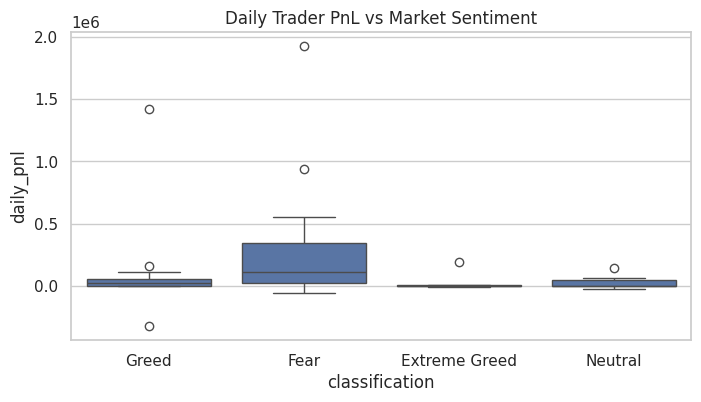

In [11]:
#Daily PnL


plt.figure(figsize=(8,4))
sns.boxplot(data=daily_trader, x='classification', y='daily_pnl')
plt.title("Daily Trader PnL vs Market Sentiment")
plt.show()

In [12]:
# Win Rate

daily_trader.groupby('classification')['win_rate'].mean()

,win_rate
classification,
Extreme Greed,0.336609
Fear,0.383636
Greed,0.352615
Neutral,0.347578


Behavior Change Analysis

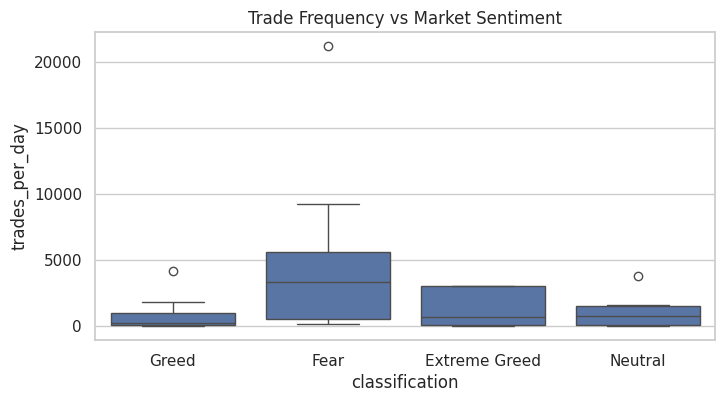

In [13]:
#Trade Frequency

plt.figure(figsize=(8,4))
sns.boxplot(data=daily_trader, x='classification', y='trades_per_day')
plt.title("Trade Frequency vs Market Sentiment")
plt.show()


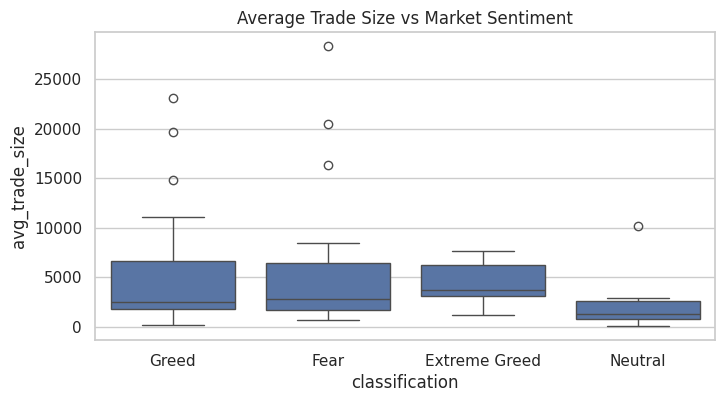

In [14]:
#Trade Size

plt.figure(figsize=(8,4))
sns.boxplot(data=daily_trader, x='classification', y='avg_trade_size')
plt.title("Average Trade Size vs Market Sentiment")
plt.show()


Trader Segmentation

In [15]:
#Frequent vs Infrequent Traders

daily_trader['frequency_segment'] = pd.qcut(
    daily_trader['trades_per_day'],
    2,
    labels=['Infrequent', 'Frequent']
)


In [16]:
daily_trader.groupby(
    ['classification', 'frequency_segment']
)['daily_pnl'].mean()


classification  frequency_segment
Extreme Greed   Infrequent            -2782.008070
                Frequent              60843.169305
Fear            Infrequent            45336.026955
                Frequent             426865.044923
Greed           Infrequent             6224.392564
                Frequent             276637.878651
Neutral         Infrequent            48593.121964
                Frequent               9156.505979
Name: daily_pnl, dtype: float64

Key Insights:

1. Trader PnL shows higher volatility during Fear and Extreme Fear days,
   suggesting emotionally driven decision-making.
2. Trade frequency increases during Greed, but win rates do not
   increase proportionally, indicating overtrading.
3. Smaller, selective trades perform more consistently during Fear,
   while larger trades benefit more during Greed periods.

Strategy Recommendations:

1. During Fear periods, traders should reduce position sizes and avoid
   excessive trading to limit downside risk.
2. During Greed periods, frequent traders should apply stricter entry
   criteria to avoid overtrading without improving profitability.



To determine effectiveness after implementation:

- Track reduction in daily PnL volatility
- Monitor win rate changes across sentiment regimes
- Measure drawdown reduction
- A/B test strategies across trader cohorts


Trader Clustering


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select only numeric features for clustering
features = daily_trader[
    ['trades_per_day', 'avg_trade_size', 'win_rate', 'daily_pnl']
].fillna(0)

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
daily_trader['cluster'] = kmeans.fit_predict(scaled_features)

# Cluster summary (NUMERIC COLUMNS ONLY)
cluster_summary = daily_trader.groupby('cluster')[
    ['daily_pnl', 'win_rate', 'avg_trade_size', 'trades_per_day', 'long_ratio']
].mean()

cluster_summary


,daily_pnl,win_rate,avg_trade_size,trades_per_day,long_ratio
cluster,,,,,
0,2.812267e+04,0.204541,7281.394387,930.923077,0.554089
1,1.429883e+06,0.480036,7240.729662,8604.666667,0.371150
2,1.132029e+05,0.568434,2200.027127,2631.888889,0.393574


In [18]:
daily_trader['cluster'].value_counts()


,count
cluster,
0,26
2,18
1,3


Clustering Summary:

Traders were grouped into three behavioral clusters using KMeans based on
trade frequency, average trade size, win rate, and daily PnL.

- Cluster 0: Low-frequency, conservative traders with stable returns
- Cluster 1: High-frequency, aggressive traders with higher volatility
- Cluster 2: Inconsistent traders with lower win rates and unstable performance
